In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/test/train.csv")

In [ ]:
df.shape

(527040, 17)

In [ ]:
#df.head()

In [ ]:
df = df[df['Total Cloud Cover [%]'] >= -1]

In [ ]:
#df.corr()

In [ ]:
df.rename(columns = {'Direct sNIP [W/m^2]':'snip', 'Total Cloud Cover [%]': 'cloud cover', 
                     'Peak Wind Speed @ 6ft [m/s]': 'wind speed', 
                     'Avg Wind Direction @ 6ft [deg from N]': 'wind dir',
                     'Tower RH [%]': 'rh', 'Global CMP22 (vent/cor) [W/m^2]': 'cmp22',
                     'Tower Dew Point Temp [deg C]': 'temp', 'Moisture': 'moisture',
                     }, inplace = True)

In [ ]:
req_cols = ['snip', 'wind speed', 'cloud cover']

df = df[req_cols]

df.head()

,snip,wind speed,cloud cover
0,0.000000,9.95,-1
1,0.000000,8.20,-1
2,0.000000,6.70,-1
3,-0.029673,7.70,-1
4,-0.054401,7.20,-1


In [ ]:
df.shape

(525511, 3)

In [ ]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

420408 105103


# Preprocessing

In [ ]:
#df.head()

In [ ]:
from sklearn.preprocessing import RobustScaler

f_columns = ['snip', 'wind speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cloud cover']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cloud cover'] = cnt_transformer.transform(train[['cloud cover']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cloud cover'] = cnt_transformer.transform(test[['cloud cover']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [ ]:
#(train['moisture'] < 0.5).sum()

In [ ]:
def create_dataset(X, y, time_steps, ccmin):
  Xs, ys = [], []
  for i in range(len(X)- 60 - time_steps):
    if (y.to_numpy()[i] == ccmin) or (y.to_numpy()[i + 60 + time_steps] == ccmin):
      continue
    Xs.append(X.iloc[i:(i + 60)].values)        
    ys.append(y.iloc[i + 60 + time_steps])
  return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 60

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train['cloud cover'], time_steps, train['cloud cover'].min())
X_test, y_test = create_dataset(test, test['cloud cover'], time_steps, train['cloud cover'].min())

print(X_train.shape, y_train.shape)

(175767, 60, 3) (175767,)


In [ ]:
train['cloud cover'].min()

-0.06521739130434782

In [ ]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=16, 
      input_shape=(X_train.shape[1], X_train.shape[2]),
      return_sequences=False
    )
  )
)
model.add(keras.layers.Dropout(rate=0.1))
'''
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=64, 
      #input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.1))
'''
opt = keras.optimizers.Adam(learning_rate=0.005)
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer=opt)

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=360, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/100
440/440 [==============================] - 20s 26ms/step - loss: 0.2650 - val_loss: 0.1622
Epoch 2/100
440/440 [==============================] - 11s 24ms/step - loss: 0.2366 - val_loss: 0.1652
Epoch 3/100
440/440 [==============================] - 11s 24ms/step - loss: 0.2308 - val_loss: 0.1679
Epoch 4/100
440/440 [==============================] - 11s 24ms/step - loss: 0.2276 - val_loss: 0.1650
Epoch 5/100
440/440 [==============================] - 11s 24ms/step - loss: 0.2257 - val_loss: 0.1636
Epoch 6/100
440/440 [==============================] - 11s 24ms/step - loss: 0.2240 - val_loss: 0.1638
Epoch 7/100
440/440 [==============================] - 11s 24ms/step - loss: 0.2230 - val_loss: 0.1617
Epoch 8/100
440/440 [==============================] - 11s 24ms/step - loss: 0.2225 - val_loss: 0.1624
Epoch 9/100
440/440 [==============================] - 11s 24ms/step - loss: 0.2213 - val_loss: 0.1603
Epoch 10/100
440/440 [==============================] - 11s 24ms/step - l

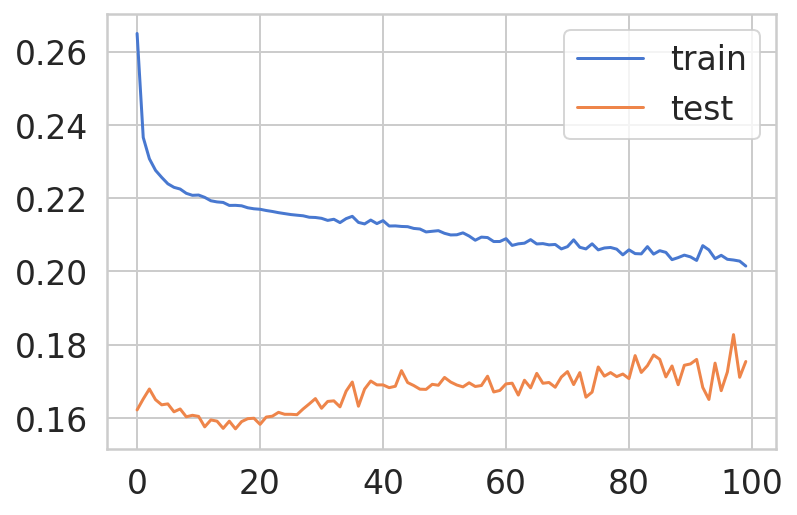

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

In [ ]:
'''
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('cloud cover')
plt.xlabel('Time Step')
plt.legend()
plt.show();
'''

'\nplt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), \'g\', label="history")\nplt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker=\'.\', label="true")\nplt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), \'r\', label="prediction")\nplt.ylabel(\'cloud cover\')\nplt.xlabel(\'Time Step\')\nplt.legend()\nplt.show();\n'

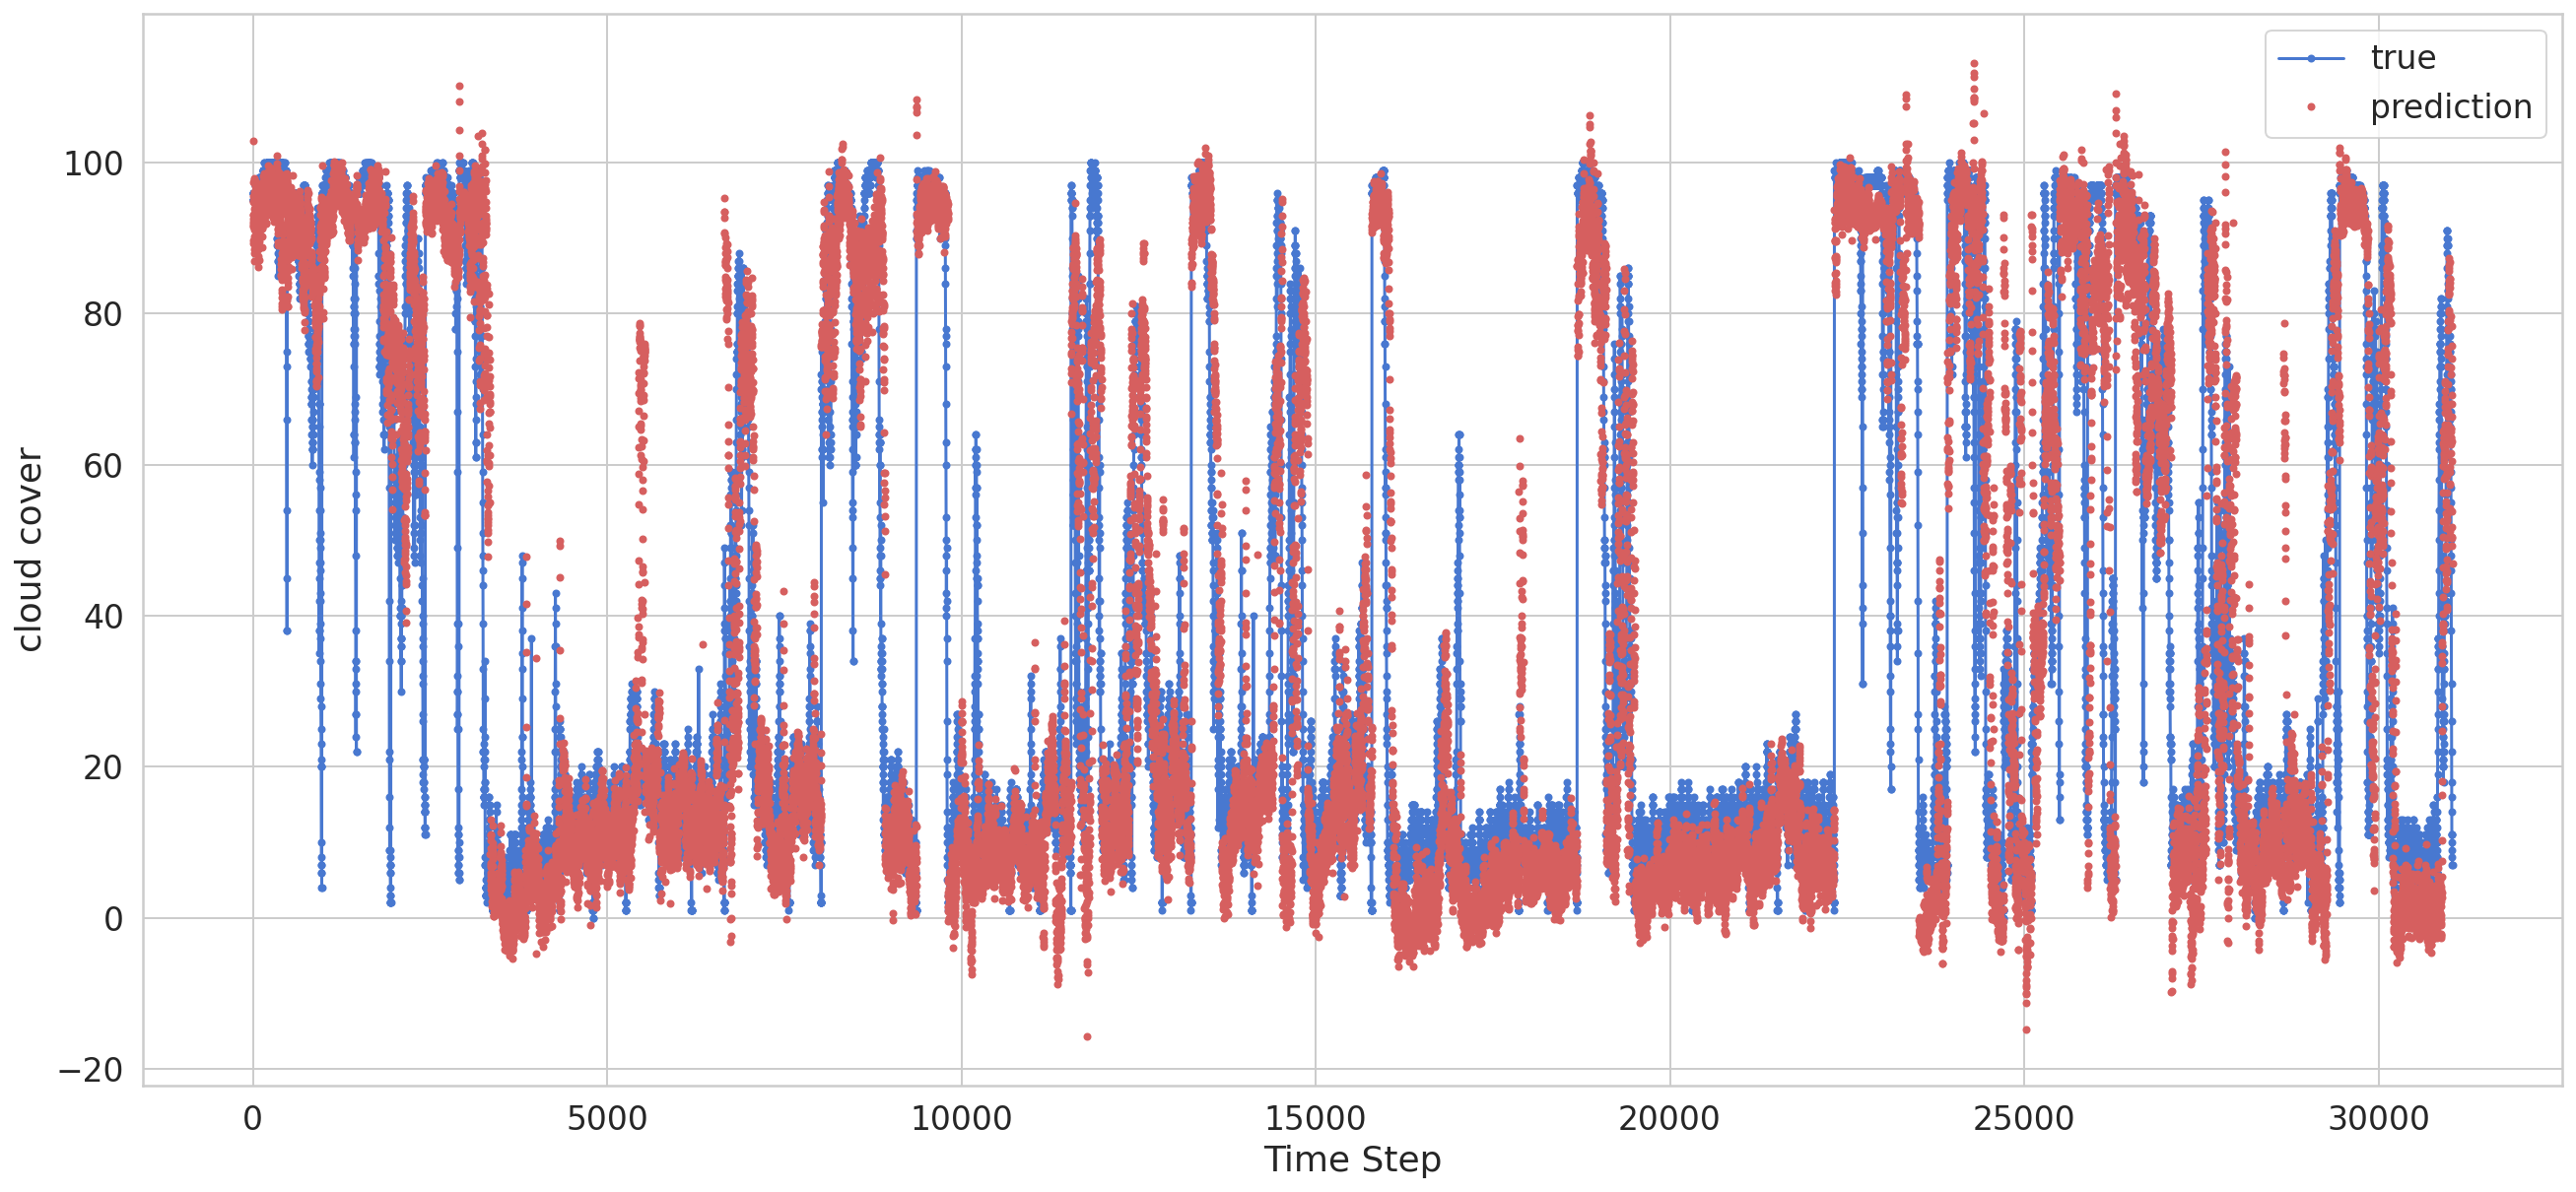

In [ ]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r.', label="prediction")
plt.ylabel('cloud cover')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
def create_dataset_test(X, time_steps):
    Xs = []
    v = X.iloc[(len(X) - 60):len(X)].values
    Xs.append(v)        
    return np.array(Xs)

In [ ]:
temp = 300

vals = np.zeros(temp)

for i in range(1,temp+1):
  df_test = pd.read_csv('/content/drive/MyDrive/test/{}/weather_data.csv'.format(i))
  df_test = df_test[df_test['Total Cloud Cover [%]'] >= 0]

  df_test.rename(columns = {'Direct sNIP [W/m^2]':'snip', 'Total Cloud Cover [%]': 'cloud cover', 
                     'Peak Wind Speed @ 6ft [m/s]': 'wind speed', 
                     'Avg Wind Direction @ 6ft [deg from N]': 'wind dir',
                     'Tower RH [%]': 'rh', 'Global CMP22 (vent/cor) [W/m^2]': 'cmp22',
                     'Tower Dew Point Temp [deg C]': 'temp', 'Moisture': 'moisture',}, inplace = True)
  req_cols = ['snip', 'wind speed', 'cloud cover']
  df_test = df_test[req_cols]

  df_test.loc[:, f_columns] = f_transformer.transform(df_test[f_columns].to_numpy())
  df_test['cloud cover'] = cnt_transformer.transform(df_test[['cloud cover']])

  X_test = create_dataset_test(df_test, time_steps)
  
  y_pred = model.predict(X_test)

  #y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
  y_pred_inv = cnt_transformer.inverse_transform(y_pred)

  vals[i-1] = y_pred_inv
  if i%30==0:
    print(int(i/3), end=' ')

10 20 30 40 50 60 70 80 90 100 

In [ ]:
vals.shape

(300,)

In [ ]:
pd.DataFrame(vals).to_csv("/content/drive/MyDrive/test/datanew{}.csv".format(time_steps))

In [ ]:
vals

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na